# Unsupervised Learning

- No labels in the dataset  
- Difficult to evaluate model quality  
- We'll focus on methods that allow **data-driven evaluation**

---



## Density Estimation

- **Aim:** Estimate the **Probability Density Function (PDF)** of the data source  
- **Useful for:**
  - Novelty detection
  - Intrusion detection
- Example: One-class classification using **Multivariate Normal Distribution (MVN)**

---



## Parametric vs Non-Parametric

- **Parametric models**:  
  Assume specific distributions (e.g., MVN)  
  - Poor performance if assumption is wrong
- **Non-parametric models**:  
  Make fewer assumptions  
  - Flexible, more adaptable  
  - Used in kernel regression and density estimation

---



## Kernel Density Estimation (KDE)

Given a dataset $\{x_i\}_{i=1}^N$, KDE estimates the PDF as:

$$
\hat{f}_b(x) = \frac{1}{Nb} \sum_{i=1}^{N} k\left(\frac{x - x_i}{b}\right)
$$

- $b$ : bandwidth (bias-variance control)
- $k(z)$: kernel (e.g., Gaussian)

---



## Gaussian Kernel

The Gaussian kernel is defined as:

$$
k(z) = \frac{1}{\sqrt{2\pi}} e^{-z^2 / 2}
$$

- Smooth and commonly used  
- Bandwidth $b$ adjusts smoothing level

---


## Basic KDE with Gaussian Kernel in PyTorch

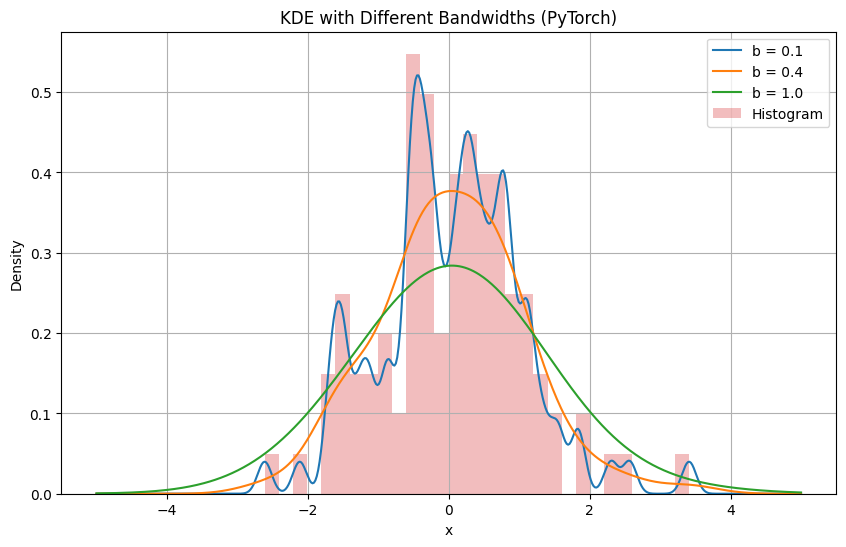

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Generate 1D synthetic data
torch.manual_seed(0)
N = 100
x_data = torch.normal(0, 1, size=(N,))

# KDE function using Gaussian kernel
def kde_pytorch(x, x_data, bandwidth):
    N = x_data.shape[0]
    diff = x[:, None] - x_data[None, :]  # shape: (len(x), N)
    kernel_vals = torch.exp(-0.5 * (diff / bandwidth)**2) / (bandwidth * torch.sqrt(torch.tensor(2 * np.pi)))
    return kernel_vals.mean(dim=1)

# Plot bandwidth effect
x_plot = torch.linspace(-5, 5, 500)

plt.figure(figsize=(10, 6))
for b in [0.1, 0.4, 1.0]:  # Try small, medium, large bandwidths
    y_kde = kde_pytorch(x_plot, x_data, b)
    plt.plot(x_plot.numpy(), y_kde.numpy(), label=f'b = {b}')

plt.hist(x_data.numpy(), bins=30, density=True, alpha=0.3, label='Histogram')
plt.legend()
plt.title("KDE with Different Bandwidths (PyTorch)")
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.show()



## Bias–Variance Trade-off : MISE

To find best $b$, minimize **Mean Integrated Squared Error (MISE)**:

$$
\text{MISE}(b) = \mathbb{E} \left[ \int_{\mathbb{R}} \left( \hat{f}_b(x) - f(x) \right)^2 dx \right]
$$

- Measures expected squared error across all datasets  
- Generalization of mean squared error to continuous functions

---



## MISE Expansion

$$
\text{MISE}(b) = \mathbb{E} \left[ \int \hat{f}_b^2(x) dx - 2 \int \hat{f}_b(x)f(x) dx + \int f^2(x) dx \right]
$$

- Last term $\int f^2(x) dx$ is **independent of $b$**  
- So we minimize:

$$
\int \hat{f}_b^2(x) dx - \frac{2}{N} \sum_{i=1}^{N} \hat{f}_b^{(i)}(x_i)
$$

---



## Leave-One-Out Estimate

- $\hat{f}_b^{(i)}(x_i)$ : density estimated **excluding $x_i$**  
- Called **Leave-One-Out Cross-Validation**  
- Gives an **unbiased estimate** of the expected value

---


In [2]:
# KDE excluding x_i (Leave-One-Out)
def leave_one_out_kde(x_data, bandwidth):
    N = x_data.shape[0]
    estimates = []
    for i in range(N):
        others = torch.cat([x_data[:i], x_data[i+1:]])
        est = kde_pytorch(x_data[i].view(1), others, bandwidth)
        estimates.append(est.item())
    return torch.tensor(estimates)



## Finding Optimal $b^*$

Minimize cost:

$$
\text{Cost}(b) = \int \hat{f}_b^2(x) dx - \frac{2}{N} \sum_{i=1}^{N} \hat{f}_b^{(i)}(x_i)
$$

- Use **grid search** to test multiple $b$ values  
- Choose $b^*$ that minimizes the cost

---


## KDE Cost function

In [3]:
def kde_squared_integral(x_data, bandwidth, grid):
    kde_vals = kde_pytorch(grid, x_data, bandwidth)
    return torch.trapz(kde_vals ** 2, grid)

def kde_cost(x_data, bandwidth, grid):
    squared_integral = kde_squared_integral(x_data, bandwidth, grid)
    loo_vals = leave_one_out_kde(x_data, bandwidth)
    return squared_integral - 2 * loo_vals.mean()


## Grid Search to Find Optimal Bandwidth

Optimal bandwidth: 0.486


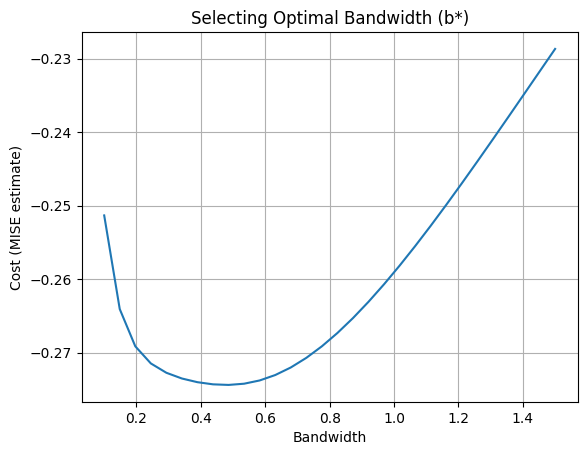

In [4]:
grid = torch.linspace(-5, 5, 500)
bandwidths = torch.linspace(0.1, 1.5, 30)
costs = [kde_cost(x_data, b, grid).item() for b in bandwidths]

optimal_b = bandwidths[torch.argmin(torch.tensor(costs))]
print(f"Optimal bandwidth: {optimal_b:.3f}")

# Plot cost vs bandwidth
plt.plot(bandwidths.numpy(), costs)
plt.xlabel("Bandwidth")
plt.ylabel("Cost (MISE estimate)")
plt.title("Selecting Optimal Bandwidth (b*)")
plt.grid(True)
plt.show()



## KDE in Higher Dimensions

For $\mathbf{x} \in \mathbb{R}^D$:

$$
\hat{f}_b(\mathbf{x}) = \frac{1}{Nb^D} \sum_{i=1}^{N} k\left( \frac{\lVert \mathbf{x} - \mathbf{x}_i \rVert}{b} \right)
$$

- Use **Euclidean distance**
- Same concept extends to multidimensional data

---


## 2D KDE for Multivariate Data

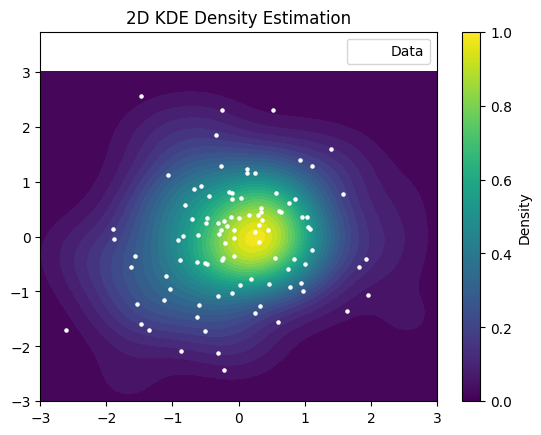

In [5]:
# 2D Data
torch.manual_seed(0)
X = torch.normal(0, 1, size=(100, 2))

def kde_2d(grid_x, data, bandwidth):
    N = data.shape[0]
    D = data.shape[1]
    diff = grid_x[:, None, :] - data[None, :, :]  # Shape: (num_points, N, D)
    norms = torch.linalg.norm(diff / bandwidth, dim=2)  # Shape: (num_points, N)
    kernels = torch.exp(-0.5 * norms ** 2) / ((2 * np.pi) ** (D/2))
    return kernels.mean(dim=1) / (bandwidth ** D)

# Create grid for 2D
x_vals = torch.linspace(-3, 3, 100)
y_vals = torch.linspace(-3, 3, 100)
grid_x, grid_y = torch.meshgrid(x_vals, y_vals, indexing="ij")
grid = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

bandwidth = 0.5
z_vals = kde_2d(grid, X, bandwidth)
z_vals = z_vals.reshape(100, 100)

plt.contourf(x_vals.numpy(), y_vals.numpy(), z_vals.numpy(), levels=30, cmap='viridis')
plt.scatter(X[:,0], X[:,1], c='white', s=5, label='Data')
plt.title("2D KDE Density Estimation")
plt.colorbar(label="Density")
plt.legend()
plt.show()



# Clustering 

- **Goal :** **Assign labels** to examples without labeled data  
- Challenge: No ground truth → Hard to evaluate model quality  
- Performance depends on unknown properties of the underlying data distribution

---



## Common Clustering Algorithms

- Many algorithms exist:
  - Centroid-based (e.g., K-Means)
  - Density-based (e.g., DBSCAN, HDBSCAN)
- No one-size-fits-all:  
  - Each algorithm behaves differently on different datasets

---



# K-Means Clustering

## Algorithm Overview

1. Choose number of clusters $k$
2. Randomly initialize $k$ **centroids** in feature space  
3. Assign each example to its **nearest centroid**  
4. Update each centroid to be the **mean of its assigned examples**  
5. Repeat steps 3–4 until assignments no longer change

---


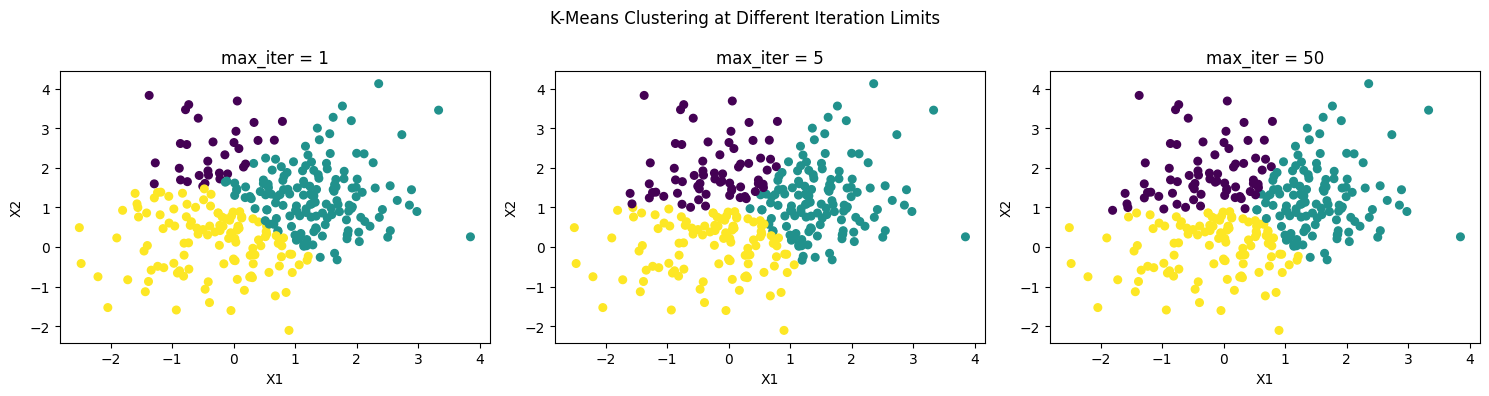

In [6]:
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generate synthetic overlapping clusters
torch.manual_seed(42)
N = 300

cluster_1 = torch.normal(0.0, 1.0, size=(N//3, 2))
cluster_2 = torch.normal(1.0, 1.0, size=(N//3, 2))
cluster_3 = torch.normal(torch.tensor([0.5, 1.5]).expand(N//3, 2), 1.0)

data = torch.cat([cluster_1, cluster_2, cluster_3], dim=0).numpy()

# Different iteration limits
iteration_limits = [1, 5, 50]

# Plot K-Means clustering at different iteration steps
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, max_iter in enumerate(iteration_limits):
    kmeans = KMeans(n_clusters=3, init='random', n_init=1, max_iter=max_iter, random_state=42)
    labels = kmeans.fit_predict(data)
    axs[i].scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=30)
    axs[i].set_title(f'max_iter = {max_iter}')
    axs[i].set_xlabel('X1')
    axs[i].set_ylabel('X2')

plt.suptitle("K-Means Clustering at Different Iteration Limits")
plt.tight_layout()
plt.show()



- Final model = **Cluster assignments** (centroid IDs)
- Sensitive to **initial centroid positions**  
  - Different runs may give different results  

---



## Tuning $k$

- $k$ is a **hyperparameter**: must be chosen manually
- No optimal method exists  
  - Use heuristics, visual inspection, or evaluation metrics  
- Later in the chapter: technique to choose $k$ **without looking at the data** 

---



# DBSCAN and HDBSCAN

## DBSCAN: Density-Based Clustering

- No need to specify $k$ !
- Instead, define two hyperparameters:
  - $\epsilon$
  - $n$ (min. neighbors)

---



## How It Works

1. Pick a random example $x$
2. If $x$'s $\epsilon$ -neighborhood has ≥ $n$ points → start cluster
3. Expand cluster by checking neighbors' neighborhoods recursively
4. Repeat for unvisited points
5. Points with < $n$ neighbors → **outliers**

---



## DBSCAN: Pros and Cons

**Advantages**:
- Can form **arbitrarily shaped** clusters  
- Automatically detects **outliers**

**Limitations**:
- Needs **good choice** of $\epsilon$ and $n$  
- Cannot handle **varying density** across clusters

---


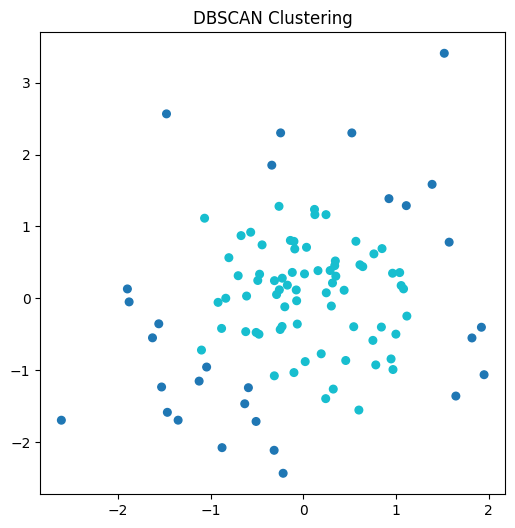

In [7]:
# DBSCAN (Using sklearn)

from sklearn.cluster import DBSCAN
import numpy as np

X_np = X.numpy()
db = DBSCAN(eps=0.5, min_samples=5).fit(X_np)
labels_db = db.labels_

# Plot DBSCAN result
plt.figure(figsize=(6, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], c=labels_db, cmap='tab10', s=30)
plt.title("DBSCAN Clustering")
plt.show()



## HDBSCAN

- Extension of DBSCAN  
- Removes need to tune $\epsilon$ 
- Can handle **clusters with different densities**

- Only one key hyperparameter:  
  → $n$ : **Minimum samples per cluster**
- Intuitive to choose  
- Works well on **large datasets**  
- Modern **K-Means is faster**, but HDBSCAN offers better flexibility and robustness.

---



 For most practical tasks, **try HDBSCAN first**  
 - Robust  
 - Scales to millions of examples  
 - Minimal tuning required

---



# Number of Clusters?

- Key question: **What is the correct number of clusters $k$ ?**
- For **1D–3D** data:  
  - Can visually inspect “clouds” or groupings  
- For **D > 3**:  
  - Visual inspection becomes difficult → need formal methods

---



## Prediction Strength : Core Idea

- Inspired by **supervised learning**
- Steps:
  1. Split data into **training** $S_{\text{tr}}$ and **test** $S_{\text{te}}$
  2. Choose a value for $k$
  3. Run clustering algorithm $C$ on both sets:
     - $C(S_{\text{tr}}, k)$
     - $C(S_{\text{te}}, k)$

---



## Building the Co-Membership Matrix

Let:

- $A = C(S_{\text{tr}}, k)$ : training clustering
- Define matrix $D[A, S_{\text{te}}]$ of size $N_{\text{te}} \times N_{\text{te}}$

$$
D[A, S_{\text{te}}](i, i') =
\begin{cases}
1 & \text{if } x_i, x_{i'} \text{ from test set are in same cluster under } A \\
0 & \text{otherwise}
\end{cases}
$$

---



- Compare clusterings from test set and training set
- If **cluster structure is stable**, test set examples that cluster together will map to same training clusters
- If not, many zeros in $D[A, S_{\text{te}}]$

---



![Photo](Images/K_9.png)


![](/Images/K_9.png)


## Prediction Strength Formula

$$
ps(k) = \min_{j = 1, ..., k} \frac{1}{|A_j|(|A_j| - 1)} \sum_{i, i' \in A_j} D[A, S_{\text{te}}](i, i')
$$

Where:
- $A = C(S_{\text{tr}}, k)$
- $A_j$ : $j^{th}$ cluster from test set clustering
- $|A_j|$ : number of examples in cluster $A_j$

---



## Intuition Behind $ps(k)$

- For each cluster $A_j$ in test set:
  - Measure fraction of point pairs that are **co-assigned** in training clustering
- Take **minimum value** across all clusters
- High prediction strength → stable clustering at that $k$

---


In [8]:


import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Wrapper function to use sklearn KMeans in prediction_strength
def sklearn_kmeans_clustering(X, k):
    # Convert PyTorch tensor to numpy array for sklearn
    X_np = X.numpy()
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = model.fit_predict(X_np)
    # Convert results back to torch tensors
    centroids = torch.tensor(model.cluster_centers_, dtype=torch.float32)
    labels_tensor = torch.tensor(labels)
    return labels_tensor, centroids

# Prediction Strength (Helper Functions)
def prediction_strength(X, k, clustering_fn, runs=1):
    strengths = []

    for _ in range(runs):
        X_tr, X_te = train_test_split(X, test_size=0.5)
        labels_tr, centroids = clustering_fn(X_tr, k)

        distances_te = torch.cdist(X_te, centroids)
        labels_te = torch.argmin(distances_te, dim=1)

        D = torch.zeros(len(X_te), len(X_te))
        for i in range(len(X_te)):
            for j in range(i+1, len(X_te)):
                # Check if pairs are clustered together in test and training sets
                same_te_cluster = labels_te[i] == labels_te[j]
                # For training labels, use modulo to avoid index issues
                same_tr_cluster = labels_tr[i % len(labels_tr)] == labels_tr[j % len(labels_tr)]
                if same_te_cluster and same_tr_cluster:
                    D[i, j] = 1
                    D[j, i] = 1

        ps = []
        for c in range(k):
            indices = (labels_te == c).nonzero(as_tuple=True)[0]
            n = len(indices)
            if n > 1:
                pairs = [(i, j) for i in indices for j in indices if i < j]
                if pairs:
                    ps.append(sum(D[i, j] for i, j in pairs) / len(pairs))
        if ps:
            strengths.append(min(ps))

    return sum(strengths) / len(strengths) if strengths else 0.0


## Selecting the Best $k$

- Choose **largest** $k$ such that:

$$
ps(k) > 0.8
$$

- If $ps(k)$ drops below threshold → clustering becomes unreliable

---


k = 2, prediction strength = 0.484
k = 3, prediction strength = 0.310
k = 4, prediction strength = 0.266
k = 5, prediction strength = 0.130
k = 6, prediction strength = 0.000


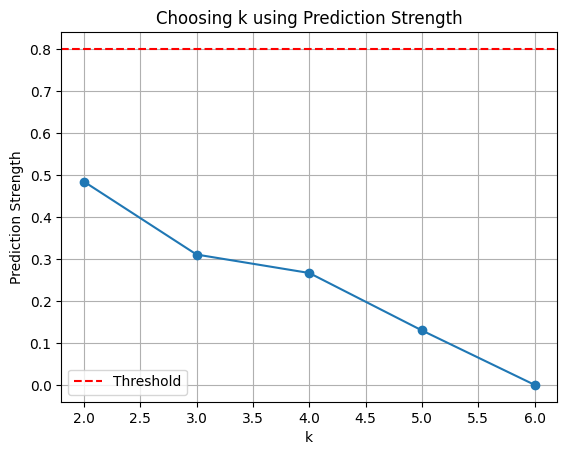

In [9]:
# Example usage on dataset X
results = []
for k in range(2, 7):
    ps_k = prediction_strength(X, k, sklearn_kmeans_clustering, runs=3)
    print(f"k = {k}, prediction strength = {ps_k:.3f}")
    results.append(ps_k)

# Plot Prediction Strength vs k
plt.plot(range(2, 7), results, marker='o')
plt.axhline(0.8, color='red', linestyle='--', label='Threshold')
plt.xlabel("k")
plt.ylabel("Prediction Strength")
plt.title("Choosing k using Prediction Strength")
plt.legend()
plt.grid(True)
plt.show()



## Multiple Runs for K-Means

- K-means is **non-deterministic**  
  - Different runs may give different results
- Solution:  
  - Run multiple times for same $k$
  - Compute **average prediction strength** :

$$
\bar{ps}(k) = \text{mean of } ps(k) \text{ over runs}
$$

---



## Other Methods to Estimate $k$

- **Gap Statistic**:
  - Compare within-cluster dispersion to random distribution
- **Elbow Method**:
  - Plot error vs. $k$ → look for "elbow"
- **Average Silhouette Score**:
  - Measures how similar a point is to its own cluster vs others

---



## Best Practices

- Use **Prediction Strength** or **Gap Statistic** for reliability  
- Run clustering **multiple times** if algorithm is non-deterministic  
- Avoid relying solely on visual inspection for **high-dimensional data**

---



# Other Clustering Algorithms

- So far : K-means and DBSCAN → **hard clustering**
  - Each point assigned to **only one cluster**
- Now: Methods that support **soft clustering**
  - Points can belong to **multiple clusters** with **probabilities**
- Example: **Gaussian Mixture Models (GMMs)**  
  (Also supported by **HDBSCAN**)

---



## Gaussian Mixture Models (GMMs)

- **Idea :** Data is generated from a mixture of **multiple Gaussian distributions**
- Each distribution represents a **cluster**
- Probability model:
  
$$
f_X(x) = \sum_{j=1}^{k} \pi_j \cdot f_{\mu_j, \sigma_j}(x)
$$

- $\pi_j$: weight (mixing coefficient) for cluster $j$  
- $f_{\mu_j, \sigma_j}$: Gaussian PDF with mean $\mu_j$ and variance $\sigma_j^2$

---



## Estimating GMM Parameters

- Use **Expectation-Maximization (EM)** algorithm to estimate:
  - Means $\mu_j$
  - Variances $\sigma_j^2$
  - Weights $\pi_j$

## EM Algorithm $(1D, k = 2)$ – Initialization

- Start with:
  - Initial guesses for $\mu_1, \sigma_1^2, \mu_2, \sigma_2^2$
  - Set $\pi_1 = \pi_2 = \frac{1}{2}$

---



## EM Algorithm Steps

### Step 1: Likelihood Calculation

$$
f(x_i | \mu_j, \sigma_j^2) = \frac{1}{\sqrt{2\pi\sigma_j^2}} \exp\left( -\frac{(x_i - \mu_j)^2}{2\sigma_j^2} \right)
$$

---



### Step 2: Posterior (Soft Assignment)

- For each $x_i$, compute:

$$
\beta_i^{(j)} = \frac{f(x_i | \mu_j, \sigma_j^2) \cdot \pi_j}{\sum_{l=1}^{k} f(x_i | \mu_l, \sigma_l^2) \cdot \pi_l}
$$

- $\beta_i^{(j)}$ : probability that point $x_i$ belongs to cluster $j$

---



### Step 3: Update Cluster Means & Variances

$$
\mu_j = \frac{\sum_{i=1}^{N} \beta_i^{(j)} x_i}{\sum_{i=1}^{N} \beta_i^{(j)}}, \quad
\sigma_j^2 = \frac{\sum_{i=1}^{N} \beta_i^{(j)} (x_i - \mu_j)^2}{\sum_{i=1}^{N} \beta_i^{(j)}}
$$

---



### Step 4: Update Cluster Weights

$$
\pi_j = \frac{1}{N} \sum_{i=1}^{N} \beta_i^{(j)}
$$

- Repeat steps **1–4** until convergence (e.g., small change in parameters)    |

---


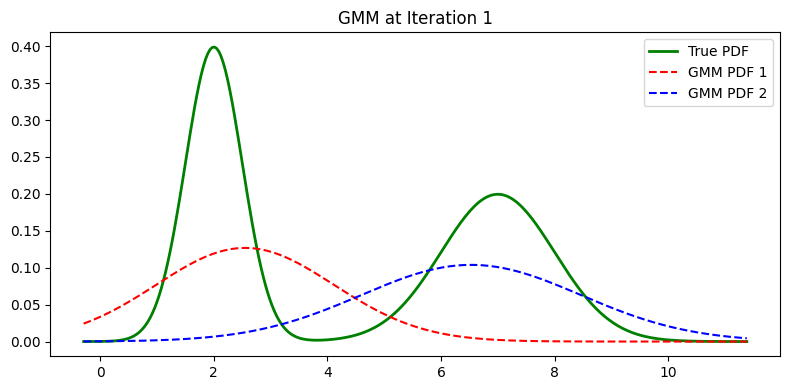

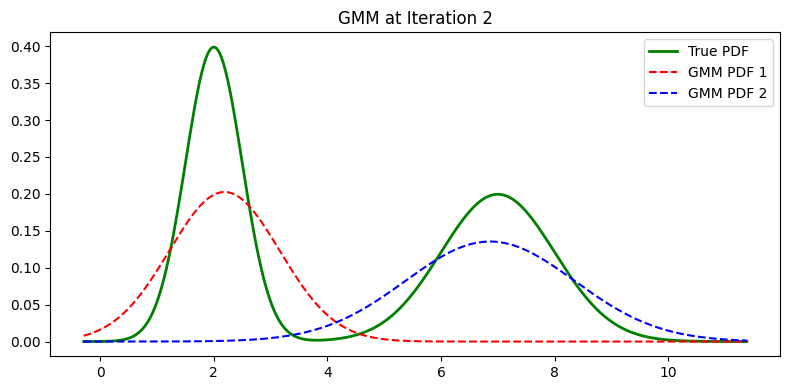

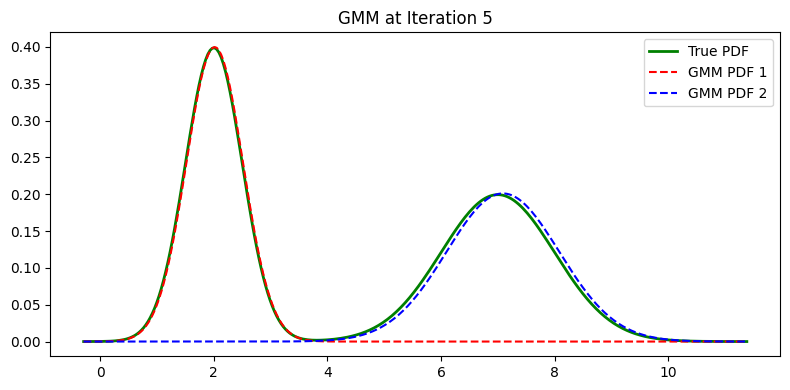

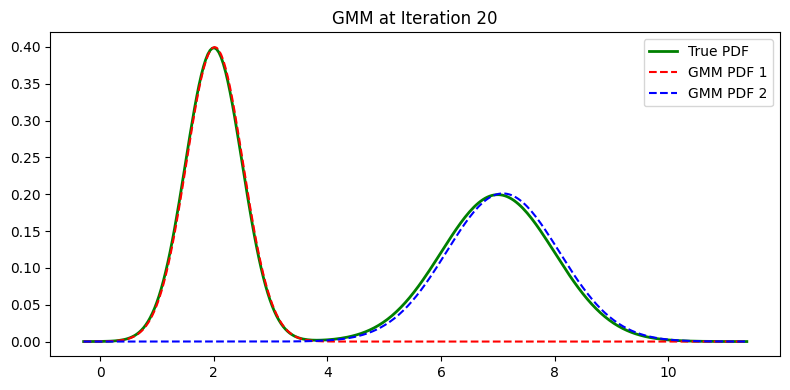

In [22]:
import torch
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate data from two Gaussians
n = 300
true_mu1, true_sigma1 = 2.0, 0.5
true_mu2, true_sigma2 = 7.0, 1.0

X1 = torch.normal(mean=true_mu1, std=true_sigma1, size=(n, 1))
X2 = torch.normal(mean=true_mu2, std=true_sigma2, size=(n, 1))
X = torch.cat([X1, X2], dim=0)

# True distribution for plotting
def true_pdf(x):
    gauss1 = torch.exp(-0.5 * ((x - true_mu1) / true_sigma1) ** 2) / (true_sigma1 * torch.sqrt(torch.tensor(2 * torch.pi)))
    gauss2 = torch.exp(-0.5 * ((x - true_mu2) / true_sigma2) ** 2) / (true_sigma2 * torch.sqrt(torch.tensor(2 * torch.pi)))
    return 0.5 * gauss1 + 0.5 * gauss2

# Initial guesses for GMM
k = 2
mu = torch.tensor([[-3.0, 12.0]])  # Shape (1, 2)
sigma = torch.tensor([[5.0, 5.0]])  # Very wide initial variances
pi = torch.tensor([0.5, 0.5])  # Equal mixing

def gaussian_pdf(x, mu, sigma):
    coef = 1.0 / (torch.sqrt(torch.tensor(2 * torch.pi)) * sigma)
    exp_part = torch.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return coef * exp_part  # Shape: (len(x), k)

x_vals = torch.linspace(X.min() - 1, X.max() + 1, 300).reshape(-1, 1)

# Show selected iterations only
show_steps = [1, 2, 5, 20]

for step in range(21):  # Only run up to 20
    # E-step
    p = gaussian_pdf(X, mu, sigma) * pi
    total = p.sum(dim=1, keepdim=True)
    gamma = p / total

    # M-step
    Nk = gamma.sum(dim=0)
    pi = Nk / len(X)
    mu = (gamma.T @ X) / Nk.unsqueeze(1)
    mu = mu.T
    diff = X - mu
    sigma = torch.sqrt((gamma * diff**2).sum(dim=0) / Nk).reshape(1, k)

    # Plot at selected steps
    if step in show_steps:
        plt.figure(figsize=(8, 4))
        true_vals = true_pdf(x_vals)
        est_pdf = gaussian_pdf(x_vals, mu, sigma) * pi

        plt.plot(x_vals.numpy(), true_vals.numpy(), label="True PDF", color="green", linewidth=2)
        plt.plot(x_vals.numpy(), est_pdf[:, 0].numpy(), label="GMM PDF 1", color="red", linestyle="--")
        plt.plot(x_vals.numpy(), est_pdf[:, 1].numpy(), label="GMM PDF 2", color="blue", linestyle="--")

        plt.title(f"GMM at Iteration {step}")
        plt.legend()
        plt.tight_layout()
        plt.show()



## GMM : Multidimensional Case

- For $D > 1$ : use **multivariate normal distributions (MNDs)**
- Variance $\sigma^2$ → becomes **covariance matrix**
  - Controls **shape**, **elongation**, **orientation** of clusters
- Advantage: Clusters can be **elliptical**, not just circular

---


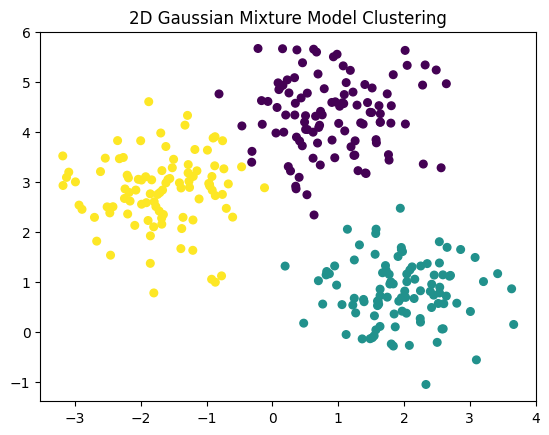

In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate 2D blobs
X, y = make_blobs(n_samples=300, centers=3, random_state=0, cluster_std=0.7)

# Fit GMM
gmm = GaussianMixture(n_components=3)
gmm.fit(X)
probs = gmm.predict_proba(X)
labels = gmm.predict(X)

# Plot soft clustering using probabilities
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
plt.title("2D Gaussian Mixture Model Clustering")
plt.show()



## Choosing Number of Clusters in GMM

- No universal method — typical approach:
  1. Split into training and test sets
  2. For each $k$, train GMM on training data → $f_k^{\text{tr}}$
  3. Compute **likelihood** of test data under the model:

$$
\text{Choose } k \text{ that maximizes } \prod_{i=1}^{N_{\text{te}}} f_k^{\text{tr}}(x_i)
$$

---


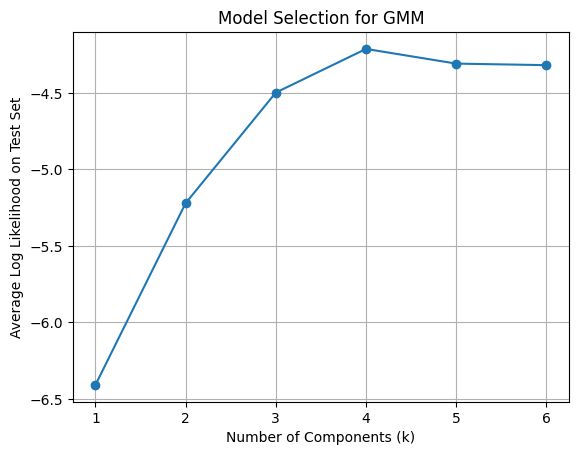

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

# Simulate data
X, _ = make_blobs(n_samples=400, centers=4, random_state=42)

# Train/test split
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# Try multiple values of k
log_likelihoods = []
k_values = range(1, 7)
for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=0)
    gmm.fit(X_train)
    score = gmm.score(X_test)  # average log-likelihood
    log_likelihoods.append(score)

plt.plot(k_values, log_likelihoods, marker='o')
plt.xlabel("Number of Components (k)")
plt.ylabel("Average Log Likelihood on Test Set")
plt.title("Model Selection for GMM")
plt.grid(True)
plt.show()



## Other Notable Clustering Algorithms

- **HDBSCAN**  
  - Like DBSCAN, but handles variable density  
  - Supports **soft assignments**

- **Spectral Clustering**  
  - Based on graph Laplacian  
  - Great for **non-convex** clusters

- **Hierarchical Clustering**  
  - Builds a **tree of clusters**  
  - Agglomerative (bottom-up) or divisive (top-down)

---



# Dimensionality Reduction 

## Why we need it?

- Modern ML algorithms (e.g., neural networks, ensembles) can handle millions of features.
- Still useful in:
  - **Visualization**: Humans can only visualize up to 3D.
  - **Model Interpretability**: Needed when using simple models like linear regression or decision trees.
  - **Noise Reduction**: Helps remove redundancy and highly correlated features.

---



## Common Dimensionality Reduction Techniques

- **Principal Component Analysis (PCA)**
- **Uniform Manifold Approximation and Projection (UMAP)**
- **Autoencoders** (already covered)

---



## PCA – Principal Component Analysis

- Projects data into new coordinate axes called **principal components**.
- First axis: direction of **highest variance** in data.
- Second axis: **orthogonal** to the first, second-highest variance, and so on.

- Reduces dimensionality while preserving most variation.
- Commonly, 2 or 3 components capture most information.

---



## UMAP – Intuition

- Designed for visualization.
- Like t-SNE, it preserves **local structure** of data.
- Defines a similarity metric combining:
  - Euclidean distance
  - Local density (distance to nearest neighbors)

---



## UMAP – Similarity Metric

Similarity between two points:

$$
w(x_i,x_j) = w_i(x_i,x_j) + w_j(x_j,x_i) - w_i(x_i,x_j) \times w_j(x_j,x_i)
$$

Where:
$$
w_i(x_i,x_j) = exp\left(\frac{ - d(xi,xj) - ρi} {σi }\right)
$$
- $ρ_i$ : distance to closest neighbor
- $σ_i$ : distance to $k^{th}$ neighbor (hyperparameter)

---



## UMAP – Optimization

- Let **w** be similarities in high-dim space, and **w'** in low-dim.
- Objective: minimize **cross-entropy** between w and w′:

$$
C(w, w′) = \sum_{i=1}^{N} \sum_{j=1}^N w(x_i, x_j) ln \left(\frac {w(x_i, x_j)}{w′(x'_i, x'_j)} \right) + \left(1 - w(x_i, x_j)\right)  ln\left(\frac {1- w(x_i, x_j)}{1 - w′(x'_i, x'_j)} \right)
$$

- Minimized using **gradient descent**.
- Outputs low-dimensional representation x′ for each input x.

---



## UMAP – Example

- Applied to **MNIST** handwritten digits dataset.
- 70,000 labeled examples (10 digits).
- Each point colored by digit class.
- UMAP separates clusters visually **without using labels**.

---


c:\Users\sriya\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


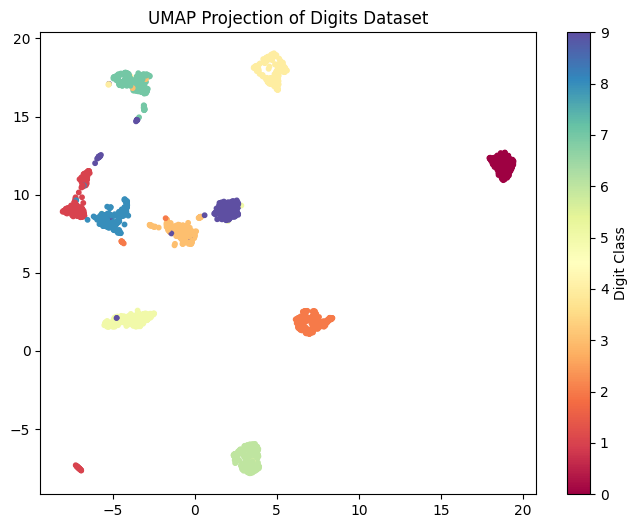

In [13]:
import umap
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Load MNIST-like digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# Apply UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
embedding = reducer.fit_transform(X)

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap="Spectral", s=10)
plt.title("UMAP Projection of Digits Dataset")
plt.colorbar(label='Digit Class')
plt.show()


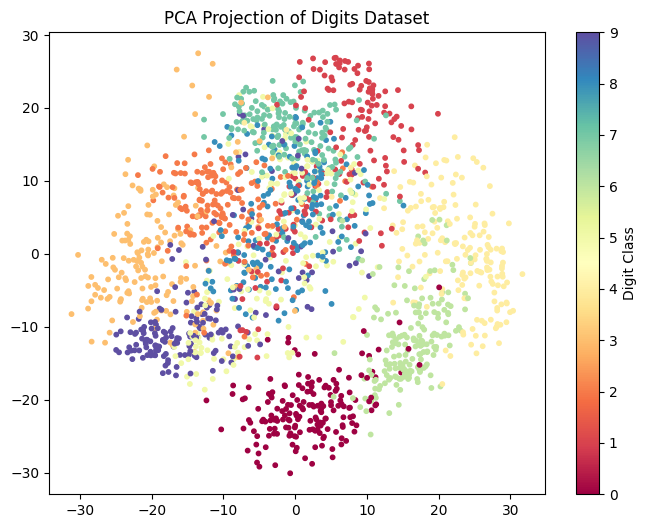

In [25]:
# Similar plot with PCA 

from sklearn.decomposition import PCA

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

# Load data
digits = load_digits()
X = digits.data
y = digits.target

# Apply PCA
pca = PCA(n_components=2)  # do NOT specify svd_solver here
pca_embedding = pca.fit_transform(X)

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], c=y, cmap="Spectral", s=10)
plt.title("PCA Projection of Digits Dataset")
plt.colorbar(label='Digit Class')
plt.show()


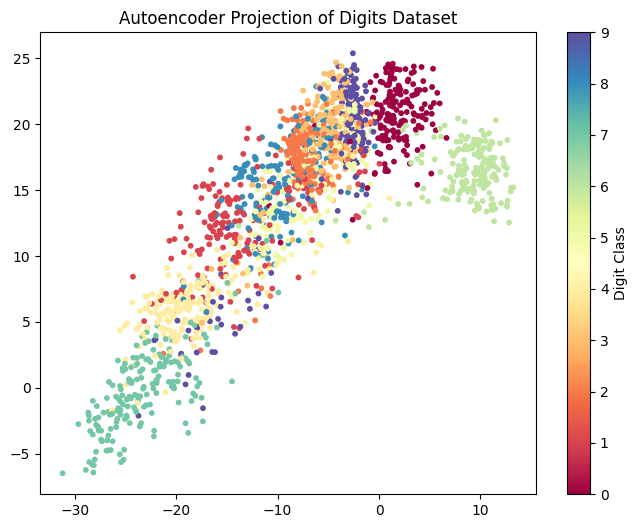

In [26]:
# With autoencoder

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Prepare data
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor, X_tensor)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

# Define autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # 2D bottleneck
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

model = Autoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Train autoencoder
for epoch in range(30):
    for xb, _ in loader:
        optimizer.zero_grad()
        recon = model(xb)
        loss = loss_fn(recon, xb)
        loss.backward()
        optimizer.step()

# Get 2D embeddings
with torch.no_grad():
    Z = model.encoder(X_tensor).numpy()

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap="Spectral", s=10)
plt.title("Autoencoder Projection of Digits Dataset")
plt.colorbar(label='Digit Class')
plt.show()



# Outlier Detection 
## Introduction

- **Goal:** Identify examples very **different** from typical ones.
- **Useful in:**
  - Fraud detection
  - Anomaly monitoring
  - Quality control

---



## Outlier Detection Techniques

1. **Autoencoder-Based**
   - Train on normal data.
   - Outliers are **poorly reconstructed**.
2. **One-Class Classification**
   - Model learns to recognize “normal”.
   - Any deviation = outlier.

---



## Autoencoder for Outliers

- Autoencoder is trained on all examples.
- Compresses and reconstructs.
- For **normal** examples: low reconstruction error.
- For **outliers**: high reconstruction error.

---


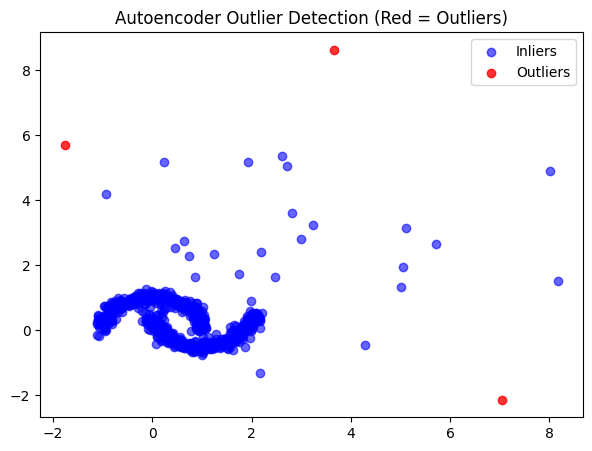

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Create synthetic dataset
X, _ = make_moons(n_samples=600, noise=0.1, random_state=42)
X = torch.tensor(X, dtype=torch.float32)

# Inject a few outliers
num_outliers = 30
outliers = torch.randn(num_outliers, 2) * 2 + torch.tensor([3.0, 3.0])  # spread-out noise
X = torch.cat([X, outliers], dim=0)

# Train-test split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Define autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 2)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, X_train)
    loss.backward()
    optimizer.step()

# Evaluate reconstruction error
model.eval()
with torch.no_grad():
    reconstructions = model(X)
    errors = torch.mean((reconstructions - X) ** 2, dim=1)

# Set a threshold (e.g., based on visual inspection or top k)
threshold = 0.5
is_outlier = errors > threshold

# Plot with outliers marked in red
X_np = X.numpy()
plt.figure(figsize=(7, 5))
plt.scatter(X_np[~is_outlier, 0], X_np[~is_outlier, 1], color='blue', label='Inliers', alpha=0.6)
plt.scatter(X_np[is_outlier, 0], X_np[is_outlier, 1], color='red', label='Outliers', alpha=0.8)
plt.title("Autoencoder Outlier Detection (Red = Outliers)")
plt.legend()
plt.show()



## One-Class Classifier

- Learns a decision boundary around **normal** data.
- At test time:
  - If input is inside boundary → accepted.
  - Else → flagged as outlier.

---
